In [2]:
from music_generator.synthesizer.oscillators import SineOscillator
from music_generator.basic.signalproc import SamplingInfo
import numpy as np
from multiprocessing import Pool
from keras.layers import Dense, Input, Lambda
from keras.models import Model
import keras.backend as K
from scipy.stats import norm
import matplotlib.pyplot as plt
%matplotlib inline

import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
from music_generator.analysis.play import play_array

/home/marcelra/Pycharmprojects/music-generator/venv/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
sampling_info = SamplingInfo(44100)

In [3]:
osc = SineOscillator(sampling_info)

In [15]:
n_timesteps = 1024
time = n_timesteps / 44100
n_samples = 400000

In [16]:
def generate_wave_packet(time, amp, freq, phase, location, sigma):
    tone = np.sin(np.arange(n_timesteps) * freq / 44100 * 2 * np.pi + phase)  # osc.generate(1, time, freq, phase)
    envelope = norm.pdf(np.arange(n_timesteps), loc=location, scale=sigma)
    envelope = envelope / (np.max(envelope) * amp)
    return tone * envelope 

In [17]:
def generate_sample(ii):
    n_freqs = np.random.randint(1, 16)
    amps = np.random.uniform(0.2, 1, size=n_freqs)
    freqs = np.random.uniform(0, sampling_info.nyquist / 16, size=n_freqs)
    locs = np.random.uniform(0, n_timesteps, size=n_freqs)
    sigmas = np.random.uniform(10, n_timesteps * 5, size=n_freqs)    
    phases1 = np.random.uniform(0, 2*np.pi, size=n_freqs)
    phases2 = np.random.uniform(0, 2*np.pi, size=n_freqs)
    x = np.array([generate_wave_packet(time, amp, freq, phase, location, sigma) 
                  for amp, freq, phase, location, sigma in zip(amps, freqs, phases1, locs, sigmas)]).sum(axis=0)
    y = np.array([generate_wave_packet(time, amp, freq, phase, location, sigma) 
                  for amp, freq, phase, location, sigma in zip(amps, freqs, phases2, locs, sigmas)]).sum(axis=0)
    return np.array([x, y]).T.reshape(-1, 2)

In [18]:
with Pool(8) as pool:
    x_train = np.array(pool.map(generate_sample, range(n_samples)))

In [23]:
# plt.figure(figsize=[16, 8])
# plt.plot(x_train[index, :, 0])
# plt.plot(x_train[index, :, 1])
# plt.show()

# index = 0
# while True:
#     index += 1
#     play_array(np.repeat(x_train[index, :, 0].reshape(1, -1), 16, axis=0).reshape(-1))
#     # play_array(np.repeat(x_train[index, :, 1].reshape(1, -1), 1, axis=0).reshape(-1))

In [58]:
np.mgrid[0:4, 0:5][0].reshape(-1.)

array([0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3])

In [37]:
x_train[index, :].shape

(1024, 2)

In [28]:
inp = Input(shape=(x_train[0].shape[0], 2))

inp0 = Lambda(lambda x: x[:, :, 0])(inp)
inp1 = Lambda(lambda x: x[:, :, 1])(inp)

inp_transform0 = Dense(512, use_bias=True)
inp_transform1 = Dense(512, use_bias=True)

freq_space0 = inp_transform0(inp0)
freq_space1 = inp_transform1(inp1)

reco_layer = Dense(x_train[0].shape[0])
reco = reco_layer(freq_space0)

def delta(args):
    freq_space0, freq_space1 = args
    return freq_space0 - freq_space1

delta_layer = Lambda(delta, output_shape=(512,))([freq_space0, freq_space1])

def my_loss(y_true, y_pred):
    reco_true = y_true
    pred_delta_layer, pred_output = delta_layer, y_pred
    mse_hidden = K.mean(K.square(pred_delta_layer))
    mse_reco = K.mean(K.square(pred_output - reco_true))
    return mse_hidden + mse_reco

model = Model(inp, outputs=[delta_layer, reco])
model.summary()
model.compile('Adam', 'mse')

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 1024, 2)      0                                            
__________________________________________________________________________________________________
lambda_7 (Lambda)               (None, 1024)         0           input_5[0][0]                    
__________________________________________________________________________________________________
lambda_8 (Lambda)               (None, 1024)         0           input_5[0][0]                    
__________________________________________________________________________________________________
dense_7 (Dense)                 (None, 512)          524800      lambda_7[0][0]                   
__________________________________________________________________________________________________
dense_8 (D

In [29]:
inp_ae = Input(shape=(x_train[0].shape[0],))
transformed_ae = inp_transform0(inp_ae)
reconstructed_ae = reco_layer(transformed_ae)
ae_model = Model(inp_ae, reconstructed_ae)

In [33]:
model.fit(x_train, [np.zeros(shape=(len(x_train), 512)), x_train[:, :, 0]], epochs=250, batch_size=1024)

Epoch 1/250
400000/400000 [==============================] - 24s 60us/step - loss: 3.6666 - lambda_9_loss: 2.4044 - dense_9_loss: 1.2622
Epoch 2/250
400000/400000 [==============================] - 24s 59us/step - loss: 0.7707 - lambda_9_loss: 0.6667 - dense_9_loss: 0.1040
Epoch 3/250
400000/400000 [==============================] - 24s 59us/step - loss: 0.5802 - lambda_9_loss: 0.4604 - dense_9_loss: 0.1198
Epoch 4/250
400000/400000 [==============================] - 24s 59us/step - loss: 0.4968 - lambda_9_loss: 0.3665 - dense_9_loss: 0.1304
Epoch 5/250
400000/400000 [==============================] - 24s 59us/step - loss: 0.4527 - lambda_9_loss: 0.3120 - dense_9_loss: 0.1407
Epoch 6/250
400000/400000 [==============================] - 24s 59us/step - loss: 0.4286 - lambda_9_loss: 0.2778 - dense_9_loss: 0.1507
Epoch 7/250
400000/400000 [==============================] - 24s 59us/step - loss: 0.4115 - lambda_9_loss: 0.2530 - dense_9_loss: 0.1585
Epoch 8/250
400000/400000 [==============

400000/400000 [==============================] - 24s 60us/step - loss: 0.1515 - lambda_9_loss: 0.0806 - dense_9_loss: 0.0709
Epoch 120/250
400000/400000 [==============================] - 24s 60us/step - loss: 0.1461 - lambda_9_loss: 0.0793 - dense_9_loss: 0.0667
Epoch 121/250
400000/400000 [==============================] - 24s 60us/step - loss: 0.1419 - lambda_9_loss: 0.0788 - dense_9_loss: 0.0631
Epoch 122/250
400000/400000 [==============================] - 24s 60us/step - loss: 0.1519 - lambda_9_loss: 0.0805 - dense_9_loss: 0.0714
Epoch 123/250
400000/400000 [==============================] - 24s 59us/step - loss: 0.1361 - lambda_9_loss: 0.0776 - dense_9_loss: 0.0585
Epoch 124/250
400000/400000 [==============================] - 24s 59us/step - loss: 0.1453 - lambda_9_loss: 0.0791 - dense_9_loss: 0.0662
Epoch 125/250
400000/400000 [==============================] - 24s 60us/step - loss: 0.1436 - lambda_9_loss: 0.0794 - dense_9_loss: 0.0642
Epoch 126/250
400000/400000 [============

400000/400000 [==============================] - 24s 59us/step - loss: 0.1330 - lambda_9_loss: 0.0738 - dense_9_loss: 0.0592
Epoch 179/250
400000/400000 [==============================] - 24s 59us/step - loss: 0.1418 - lambda_9_loss: 0.0759 - dense_9_loss: 0.0659
Epoch 180/250
400000/400000 [==============================] - 24s 60us/step - loss: 0.1285 - lambda_9_loss: 0.0723 - dense_9_loss: 0.0561
Epoch 181/250
400000/400000 [==============================] - 24s 60us/step - loss: 0.1413 - lambda_9_loss: 0.0753 - dense_9_loss: 0.0660
Epoch 182/250
400000/400000 [==============================] - 24s 59us/step - loss: 0.1410 - lambda_9_loss: 0.0756 - dense_9_loss: 0.0654
Epoch 183/250
400000/400000 [==============================] - 24s 59us/step - loss: 0.1231 - lambda_9_loss: 0.0709 - dense_9_loss: 0.0521
Epoch 184/250
400000/400000 [==============================] - 24s 59us/step - loss: 0.1385 - lambda_9_loss: 0.0749 - dense_9_loss: 0.0636
Epoch 185/250
400000/400000 [============

400000/400000 [==============================] - 24s 59us/step - loss: 0.1327 - lambda_9_loss: 0.0715 - dense_9_loss: 0.0612
Epoch 238/250
400000/400000 [==============================] - 24s 59us/step - loss: 0.1242 - lambda_9_loss: 0.0696 - dense_9_loss: 0.0546
Epoch 239/250
400000/400000 [==============================] - 23s 58us/step - loss: 0.1410 - lambda_9_loss: 0.0732 - dense_9_loss: 0.0678
Epoch 240/250
400000/400000 [==============================] - 23s 58us/step - loss: 0.1190 - lambda_9_loss: 0.0682 - dense_9_loss: 0.0508
Epoch 241/250
400000/400000 [==============================] - 23s 58us/step - loss: 0.1355 - lambda_9_loss: 0.0725 - dense_9_loss: 0.0630
Epoch 242/250
400000/400000 [==============================] - 23s 59us/step - loss: 0.1357 - lambda_9_loss: 0.0717 - dense_9_loss: 0.0641
Epoch 243/250
400000/400000 [==============================] - 23s 58us/step - loss: 0.1262 - lambda_9_loss: 0.0702 - dense_9_loss: 0.0561
Epoch 244/250
400000/400000 [============

$$h_i = \sum_j W_{ij} x_j + b_i$$

$$x_j = \sum_i \tilde{W}_{ij}(h_i - b_i)$$

In [34]:
model.save("freq_loss")

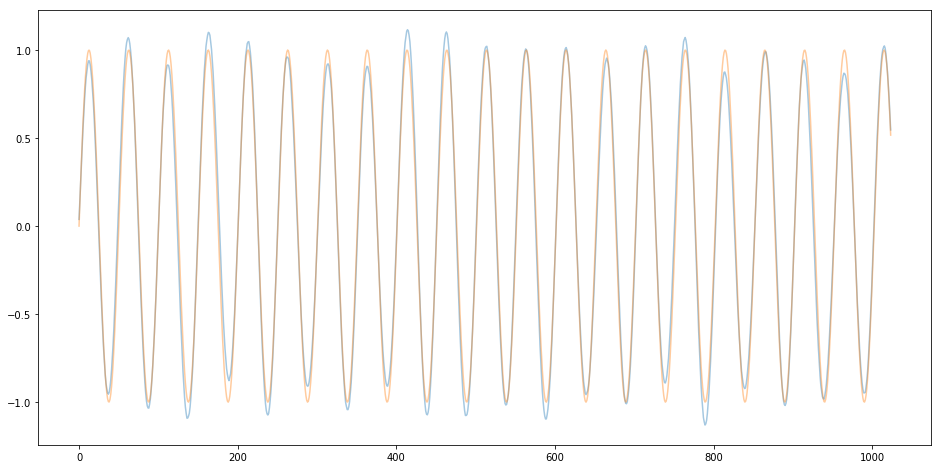

In [12]:
x_inp = osc.generate(1, time, 880, 0).reshape(1, -1)
x_inp.reshape(-1)
y = ae_model.predict(x_inp)
plt.figure(figsize=[16,8])
plt.plot(y.reshape(-1), alpha=0.4)
plt.plot(x_inp.reshape(-1), alpha=0.4)

## Pseudo-inverse

In [35]:
# activation = np.dot(W[0].T, x_inp) + W[1]
# W_inv = np.linalg.pinv(W[0].T)
# x = np.dot(W_inv, (activation - W[1]))
# plt.figure(figsize=[16,8])
# plt.plot(x, alpha=0.4)
# plt.plot(x_inp, alpha=0.4)